## Building a Drawdown and Rolling Risk Analysis

In [1]:
import warnings

In [2]:
import pandas as pd
import pyfolio as pf
from IPython.display import Markdown, display
from openbb import obb

In [3]:
warnings.filterwarnings("ignore")
obb.user.preferences.output_type = "dataframe"

Load the mean reversion performance data

In [4]:
perf = pd.read_pickle("mean_reversion.pickle")

Extract returns, positions, and transactions from Zipline performance DataFrame

In [5]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

Rename position columns to stock symbols and cash

In [6]:
positions.columns = [col.symbol for col in positions.columns[:-1]] + ["cash"]

Get the list of symbols

In [7]:
symbols = positions.columns[:-1].tolist()

Get screener data for the symbols

In [8]:
screener_data = obb.equity.profile(symbols, provider="yfinance")

Create a sector map from the screener data

In [9]:
sector_map = (
    screener_data[["symbol", "sector"]]
    .set_index("symbol")
    .reindex(symbols)
    .fillna("Unknown")
    .to_dict()["sector"]
)

Get historical price data for SPY

In [10]:
spy = obb.equity.price.historical(
    "SPY",
    start_date=returns.index.min(),
    end_date=returns.index.max(),
    provider="yfinance",
)

Convert the index to datetime and calculate the benchmark returns

In [11]:
spy.index = pd.to_datetime(spy.index)
benchmark_returns = spy.close.pct_change()
benchmark_returns.name = "SPY"
benchmark_returns = benchmark_returns.tz_localize("UTC").filter(returns.index)

Plot the top 10 drawdown periods

<Axes: title={'center': 'Top 10 drawdown periods'}, ylabel='Cumulative returns'>

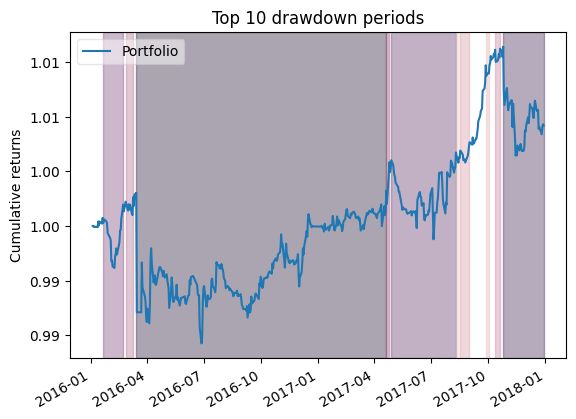

In [12]:
pf.plotting.plot_drawdown_periods(returns, top=10)

Plot the underwater plot of drawdowns

<Axes: title={'center': 'Underwater plot'}, ylabel='Drawdown'>

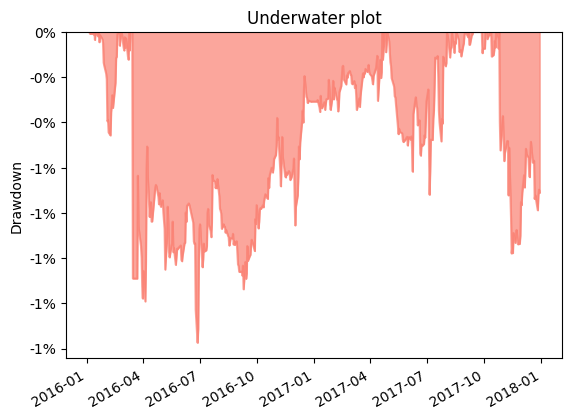

In [13]:
pf.plotting.plot_drawdown_underwater(returns)

Show the worst drawdown periods

In [14]:
pf.plotting.show_worst_drawdown_periods(returns)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.37,2016-03-14,2016-06-27,2017-04-20,289
1,0.98,2017-10-25,2017-11-14,NaT,NaN
2,0.72,2017-04-28,2017-07-05,2017-08-10,75
3,0.46,2016-01-20,2016-02-08,2016-02-22,24
4,0.12,2017-04-20,2017-04-21,2017-04-24,3


Plot the rolling volatility

<Axes: title={'center': 'Rolling volatility (6-month)'}, ylabel='Volatility'>

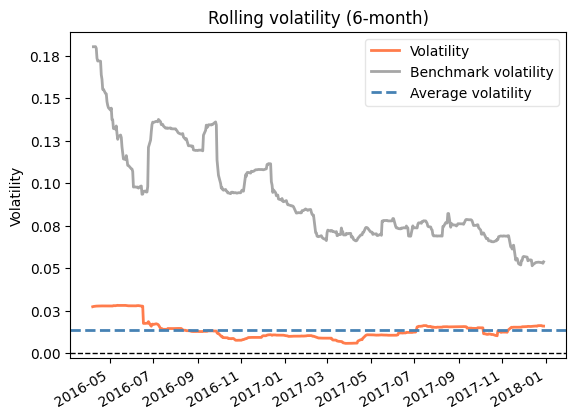

In [15]:
pf.plotting.plot_rolling_volatility(
    returns, factor_returns=benchmark_returns, rolling_window=66
)

Plot the rolling Sharpe ratio

<Axes: title={'center': 'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

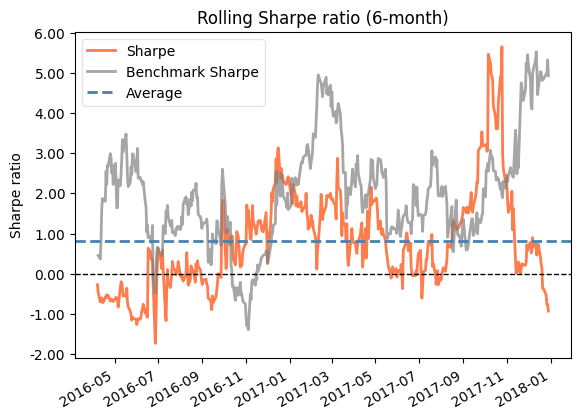

In [16]:
pf.plotting.plot_rolling_sharpe(
    returns, factor_returns=benchmark_returns, rolling_window=66
)

Extract and plot interesting date ranges

In [17]:
times = pf.timeseries.extract_interesting_date_ranges(returns)

<Axes: >

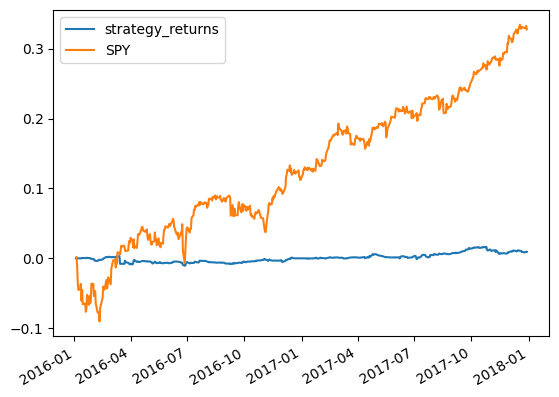

In [18]:
(
    times["New Normal"]
    .to_frame("strategy_returns")
    .join(benchmark_returns)
    .add(1)
    .cumprod()
    .sub(1)
    .plot()
)

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.